In [120]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [122]:
sectors = ['technology', 'healthcare', 'financial-services', 'energy', 'consumer-cyclical']
top_sector_dfs = []
for sector in sectors:
    top_companies = yf.Sector(sector).top_companies.head(3)
    # top_3_companies = top_companies[top_companies['rating'] == "Buy"].head(3)
    top_companies['sector'] = sector
    top_sector_dfs.append(top_companies)
    
top_companies_df = pd.concat(top_sector_dfs, axis=0)
top_companies_df

,name,rating,market weight,sector
symbol,,,,
NVDA,NVIDIA Corporation,Buy,0.187388,technology
AAPL,Apple Inc.,Buy,0.177521,technology
MSFT,Microsoft Corporation,Buy,0.162559,technology
LLY,Eli Lilly and Company,Buy,0.114839,healthcare
UNH,UnitedHealth Group Incorporated,Buy,0.082445,healthcare
JNJ,Johnson & Johnson,Buy,0.054454,healthcare
BRK-B,Berkshire Hathaway Inc.,Buy,0.100316,financial-services
JPM,JPMorgan Chase & Co.,Buy,0.079909,financial-services
V,Visa Inc.,Buy,0.059984,financial-services


In [119]:
yf.Sector('consumer-cyclical').top_companies

,name,rating,market weight
symbol,,,
AMZN,"Amazon.com, Inc.",Buy,0.304475
TSLA,"Tesla, Inc.",Hold,0.143423
HD,"The Home Depot, Inc.",Buy,0.056079
MCD,McDonald's Corporation,Buy,0.029800
BKNG,Booking Holdings Inc.,Buy,0.022756
LOW,"Lowe's Companies, Inc.",Buy,0.021392
TJX,"The TJX Companies, Inc.",Buy,0.018485
NKE,"NIKE, Inc.",Buy,0.015710
SBUX,Starbucks Corporation,Buy,0.015380


In [55]:
# Get all the symbols into a list
tickers = top_companies_df.index.to_list()
print(tickers)

['NVDA', 'AAPL', 'MSFT', 'LLY', 'UNH', 'JNJ', 'BRK-B', 'JPM', 'V', 'XOM', 'CVX', 'COP', 'AMZN', 'HD', 'MCD']


In [86]:
# Dictionaries to store data
historical_data = {}
financial_data = {}

for ticker in tickers:
    # Initialize ticker object
    stock = yf.Ticker(ticker)

    # get historical market data for 5 years
    historical_data[ticker] = stock.history(period="5y")
    historical_data[ticker]['Symbol'] = ticker

    # Get financial statements
    financial_data[ticker] = {
        "income_statement": stock.quarterly_income_stmt,
        "balance_sheet": stock.quarterly_balance_sheet,
        "cashflow": stock.quarterly_cash_flow
    }


In [116]:
historical_df = pd.concat(historical_data, axis = 0)
display(historical_df.head(5))
display(historical_df.tail(5))

Open      High       Low     Close  \
     Date                                                                
NVDA 2019-11-11 00:00:00-05:00  5.168611  5.202446  5.082281  5.179309   
     2019-11-12 00:00:00-05:00  5.217621  5.270863  5.182542  5.214885   
     2019-11-13 00:00:00-05:00  5.183537  5.211153  5.122584  5.189011   
     2019-11-14 00:00:00-05:00  5.197967  5.221603  5.138009  5.219363   
     2019-11-15 00:00:00-05:00  5.217122  5.268871  4.991719  5.080040   

                                    Volume  Dividends  Stock Splits Symbol  
     Date                                                                   
NVDA 2019-11-11 00:00:00-05:00   243436000        0.0           0.0   NVDA  
     2019-11-12 00:00:00-05:00   283504000        0.0           0.0   NVDA  
     2019-11-13 00:00:00-05:00   300188000        0.0           0.0   NVDA  
     2019-11-14 00:00:00-05:00   518080000        0.0           0.0   NVDA  
     2019-11-15 00:00:00-05:00  1053628000        0.0           0.0   NVDA

Open        High         Low       Close  \
    Date                                                                        
MCD 2024-11-04 00:00:00-05:00  294.739990  294.959991  291.799988  292.850006   
    2024-11-05 00:00:00-05:00  293.750000  297.380005  292.559998  297.320007   
    2024-11-06 00:00:00-05:00  300.279999  300.329987  292.720001  294.000000   
    2024-11-07 00:00:00-05:00  294.839996  296.540009  293.809998  294.660004   
    2024-11-08 00:00:00-05:00  295.600006  301.829987  295.250000  298.970001   

                                Volume  Dividends  Stock Splits Symbol  
    Date                                                                
MCD 2024-11-04 00:00:00-05:00  2583100        0.0           0.0    MCD  
    2024-11-05 00:00:00-05:00  3032100        0.0           0.0    MCD  
    2024-11-06 00:00:00-05:00  4646400        0.0           0.0    MCD  
    2024-11-07 00:00:00-05:00  3357400        0.0           0.0    MCD  
    2024-11-08 00:00:00-05:00  3279100        0.0           0.0    MCD

In [90]:
historical_df.to_csv('output/historical_data.csv')

In [97]:
import matplotlib.pyplot as plt

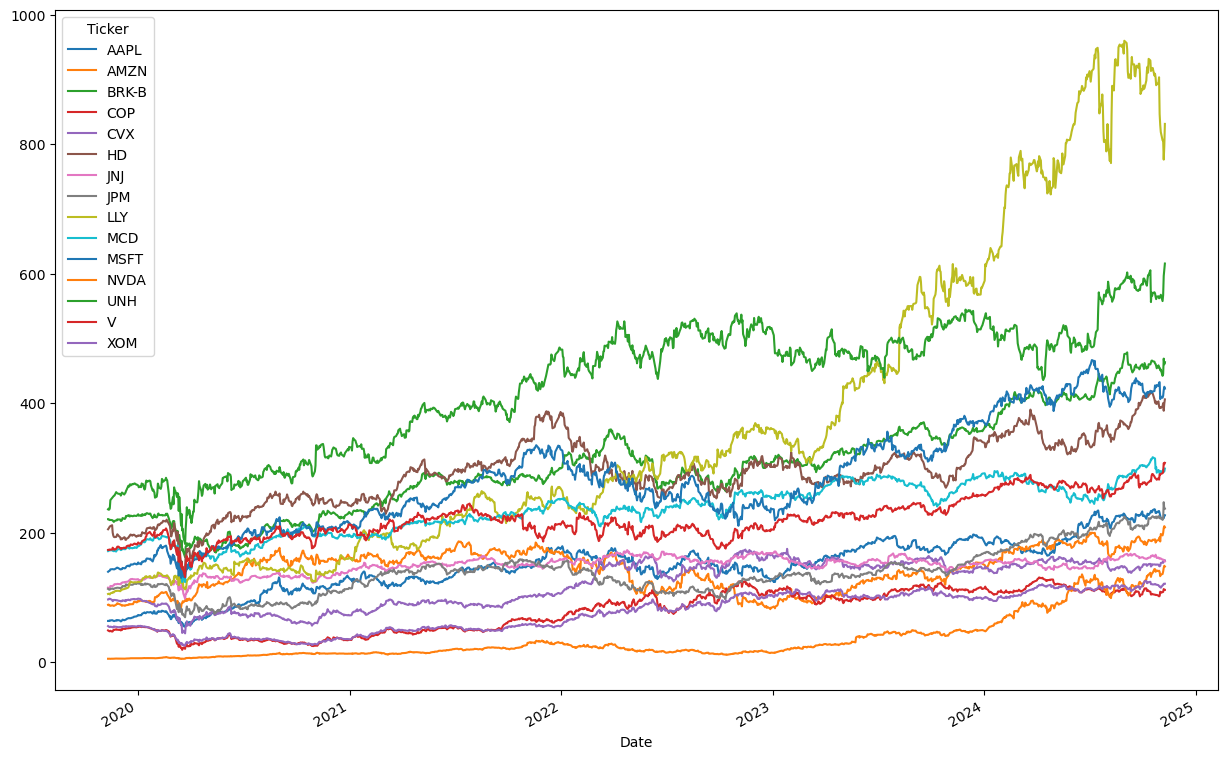

In [117]:
historical_df = historical_df.reset_index(level=0, drop=True)
historical_df.index = pd.to_datetime(historical_df.index)
historical_df.groupby('Symbol')['Close'].plot(figsize=[15,10])
plt.legend(title = 'Ticker')
plt.xlabel('Date')
plt.show()

Based on the plot, it appears that LLY (Eli Lilly's ticker symbol) has shown a significant upward trend compared to the other stocks.  So it only makes sense to analyze it further with its financials.

In [118]:
#  Slice LLY historical data and its closing price
df_LLY = historical_df[historical_df['Symbol'] == 'LLY']['Close'].to_frame()
df_LLY.head()


,Close
Date,
2019-11-11 00:00:00-05:00,105.292725
2019-11-12 00:00:00-05:00,105.638100
2019-11-13 00:00:00-05:00,105.283394
2019-11-14 00:00:00-05:00,104.574600
2019-11-15 00:00:00-05:00,106.264465
